In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from fredapi import Fred
fred = Fred(api_key='f319f875176a9291bc0355596aae91dd')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression

/Users/v.b./Documents/VS_CODE/vscode_local/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def correlation_calc(df):
    """
    Calculate and format the correlation matrix for a given DataFrame.

    Parameters:
        - df (pd.DataFrame): Input DataFrame.

    Returns:
        - pd.DataFrame: correlation matrix.
    """
    correlation_df=df.corr()
    correlation_df.values[np.tril_indices_from(correlation_df)] = np.nan
    correlation_df=correlation_df.unstack().dropna().reset_index()
    column_name= correlation_df['level_0'] + '_' + correlation_df['level_1']
    correlation_df.set_index(column_name, inplace=True)
    correlation_df.drop(['level_0', 'level_1'], axis=1, inplace=True)
    last_date = df.index.max()
    correlation_df.rename(columns={0: last_date}, inplace=True)

    return correlation_df.T


def plot_with_background_line(df, background_series, figsize=(20, 7), background_line_alpha=0.02, title='title'):
    """
    Plot a DataFrame along with a background line for specific dates.

    Parameters:
        - df (pd.DataFrame): Main data to be plotted.
        - background_series (pd.Series): Series with values 1 where background lines should be added.
        - figsize (tuple): Figure size, default is (20, 7).
        - background_line_alpha (float): Transparency of the background lines, default is 0.02.
        - title (str): Title of the plot, default is 'title'.

    Returns:
        - None: Displays the plot.
    """

    # Set figure size
    plt.figure(figsize=figsize)

    # Plot the main data without legend
    for column in df.columns:
        plt.plot(df.index, df[column])

    # Add vertical background line where the series value is 1
    background_dates = background_series.index[background_series == 1]
    for date in background_dates:
        plt.axvline(x=date, color='gray', linestyle='-', alpha=background_line_alpha, label='Background Line')

    # Add labels and legend only for the main data
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(df.columns)
    plt.grid(True)
    
    # Show the plot
    plt.show()


def geometric_mean_pctseries(s):
    """
    Calculate the geometric mean of a percentage series.

    Parameters:
        - s (pd.Series): Input percentage series.

    Returns:
        - float: Geometric mean of the input series.
    """

    geo_m = (s+1).prod() ** (1 / len(s)) - 1 
    return geo_m


def plot_time_series(series, title='Time Series Plot for States A, B, and C'):
    """
    Plot a time series with different states represented by markers and colors.

    Parameters:
        - series (pd.Series): Time series data with states as values.
        - title (str): Title of the plot, default is 'Time Series Plot for States A, B, and C'.

    Returns:
        - None: Displays the plot.
    """



    # Create a color map for each state
    state_colors = {'A': 'blue', 'B': 'green', 'C': 'red'}

    # Plotting
    plt.figure(figsize=(10, 6))

    for state in set(series):
        state_indices = series.index[series == state]
        plt.scatter(state_indices, [state] * len(state_indices),
                    label=f'State {state}', color=state_colors[state], marker='o', s=50)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('State')
    plt.yticks([], [])
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_histogram_with_percentiles(series, num_bins=30, title='title'):
    """
    Plot a histogram of a series with vertical lines indicating percentiles.

    Parameters:
        - series (np.ndarray or list): Input data for the histogram.
        - num_bins (int): Number of bins in the histogram, default is 30.
        - title (str): Title of the plot, default is 'title'.

    Returns:
        - None: Displays the plot.
    """
    # Compute statistics
    median_val = np.median(series)
    percentile_5 = np.percentile(series, 5)
    percentile_95 = np.percentile(series, 95)

    # Plot histogram
    plt.hist(series, bins=num_bins, alpha=0.7, color='blue', edgecolor='black')

    # Add vertical lines for percentiles
    plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
    plt.axvline(percentile_5, color='green', linestyle='dashed', linewidth=2, label=f'5th Percentile: {percentile_5:.2f}')
    plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95:.2f}')

    # Add labels and legend
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(title)
    # Show the plot
    plt.show()

In [3]:
spx = yf.download("^GSPC", start="1965-01-01")['Adj Close'].rename('sp500').to_frame() # we use Adj. close as it considers dividends
yield_10y = fred.get_series('DGS10').rename('yield10y').to_frame()
brl = fred.get_series('DEXBZUS').rename('brlusd').to_frame()
euro = fred.get_series('DEXUSEU').rename('eurusd').to_frame()
euro = 1/euro

df = pd.concat([spx, yield_10y, brl, euro], join='inner', axis=1)

# dropping Sat&Sun if any
df = df[df.index.dayofweek<5]

df_pct = df.pct_change().fillna(0)


# NBER based Recession Indicators for the United States
recessions = fred.get_series('USRECD').rename('nber_recession').to_frame()



# 1Y Rolling Correlation of %pctchange
WDW = 252

rolling_corr=[]

for i in range(WDW, len(df)+1):
  rolling_corr.append(correlation_calc(df_pct.iloc[i-WDW:i]))

rolling_corr = pd.concat(rolling_corr)

[*********************100%%**********************]  1 of 1 completed


/var/folders/n4/_54fp6n536xgs8n2l5_p41vw0000gn/T/ipykernel_3771/482578190.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df_pct = df.pct_change().fillna(0)


## NBER Recessions clustering

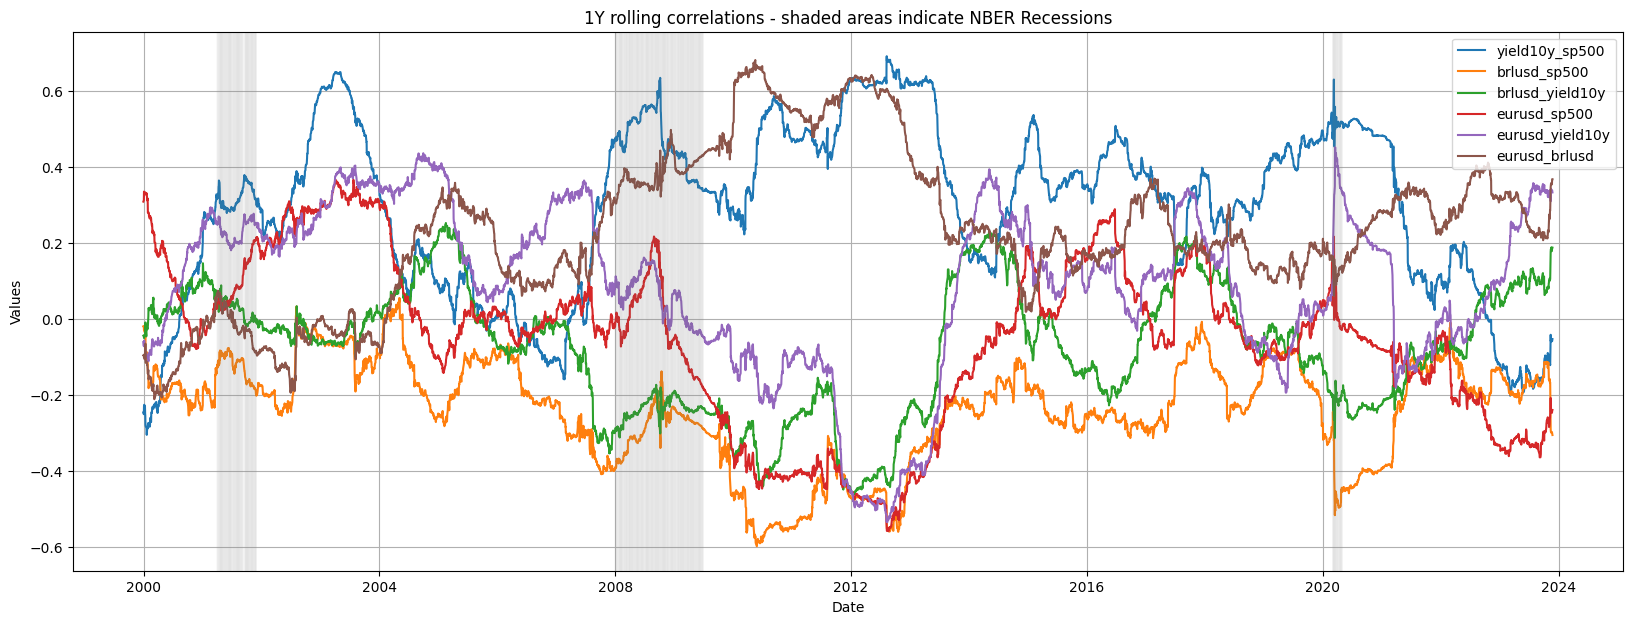

In [4]:
plot_with_background_line(rolling_corr,
                          rolling_corr.join(recessions)['nber_recession'],
                          title='1Y rolling correlations - shaded areas indicate NBER Recessions',
                          )

Text(0.5, 1.0, 'Distribution of 1Y rolling correlations from 1999-12-31 to 2023-11-24')

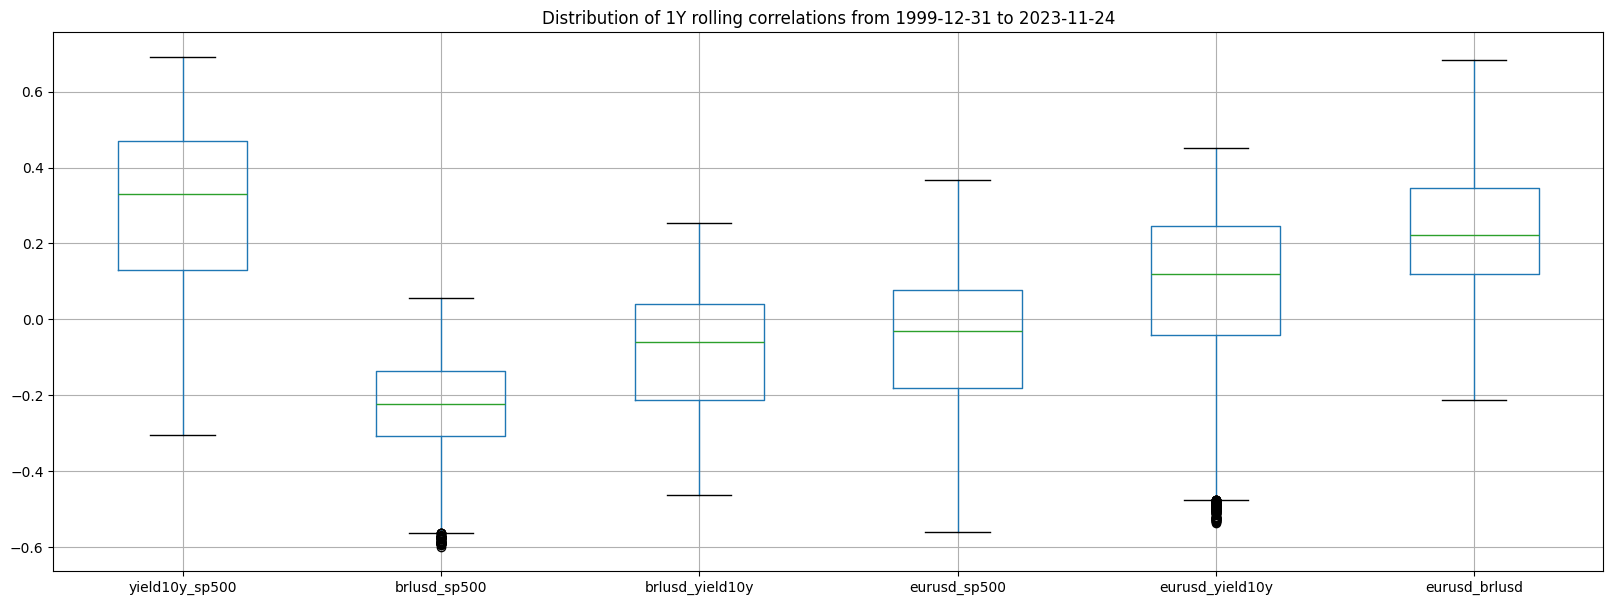

In [5]:
rolling_corr.boxplot(figsize=(20,7))
plt.title(f'Distribution of 1Y rolling correlations from {str(rolling_corr.index.min())[:10]} to {str(rolling_corr.index.max())[:10]}')

In [6]:
temp = rolling_corr.join(recessions)
corr_pctl_table = temp.groupby('nber_recession').quantile([.25, .5, 0.75]).reset_index().rename({'level_1':'percentile'}, axis=1).set_index(['nber_recession', 'percentile']).T

In [7]:
pctchg_pctl_table = df_pct.join(recessions).groupby('nber_recession').quantile([.25, .5, 0.75]).reset_index().rename({'level_1':'percentile'}, axis=1).set_index(['nber_recession', 'percentile']).T

0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

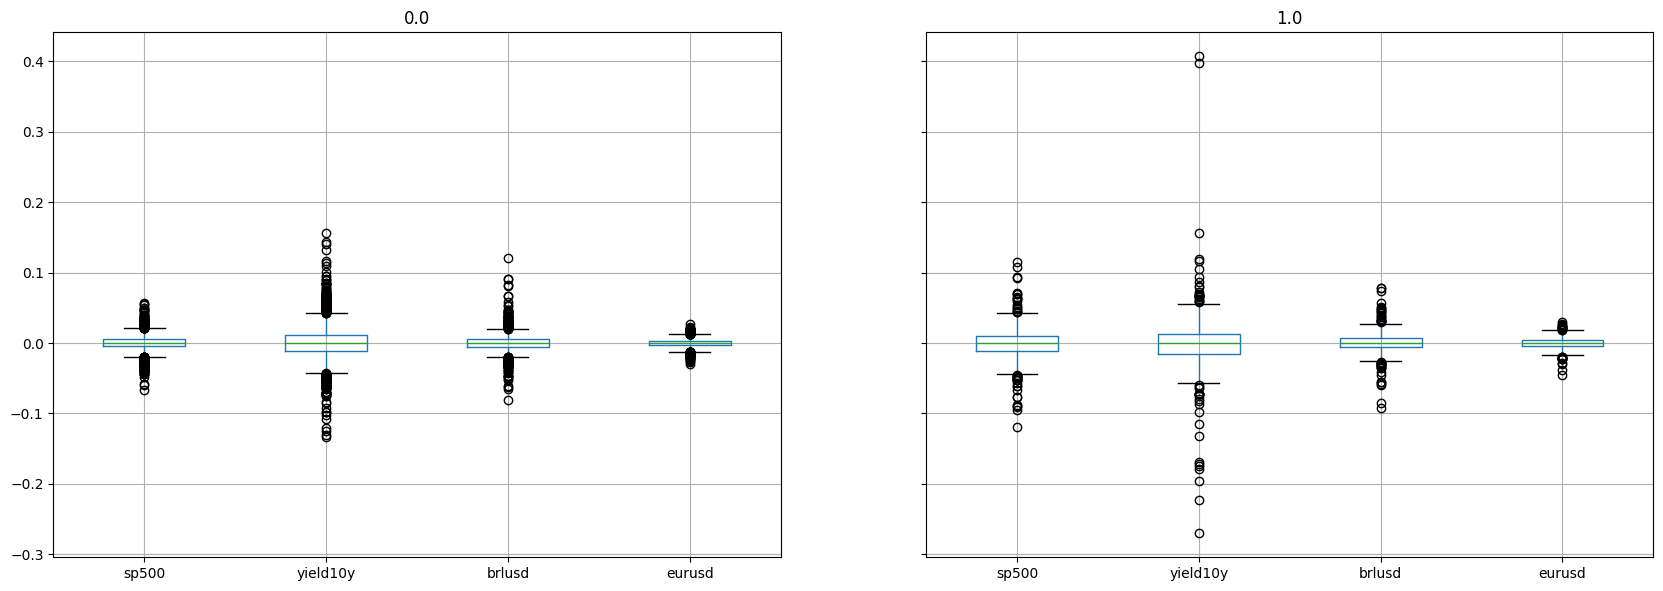

In [8]:
df_pct.join(recessions).groupby('nber_recession')[['sp500', 'yield10y', 'brlusd', 'eurusd']].boxplot(figsize=(20,7))


0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

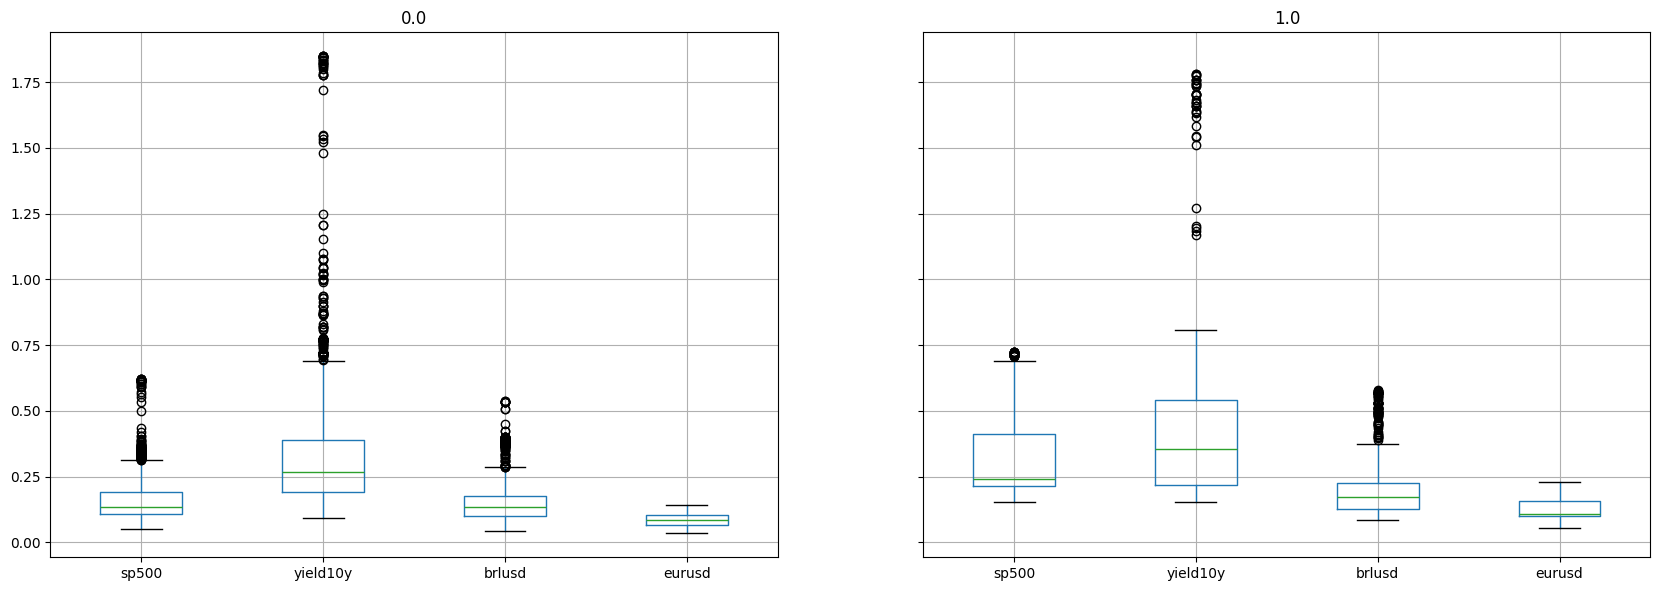

In [9]:
df_volat = df_pct.rolling(21*3).std().dropna()*252**0.5
df_volat.join(recessions).groupby('nber_recession')[['sp500', 'yield10y', 'brlusd', 'eurusd']].boxplot(figsize=(20,7))

## Unsupervised Regimes Clustering

In [10]:
nonfarm = fred.get_series('PAYEMS').rename('nonfarm').to_frame()
initclaim = fred.get_series('ICSA').rename('initclaim').to_frame()
pce = fred.get_series('PCE').rename('pce').to_frame()
indpro = fred.get_series('INDPRO').rename('indpro').to_frame()
ppi = fred.get_series('PCUOMFGOMFG').rename('ppi').to_frame() # by industry
cpi = fred.get_series('CPILFESL').rename('cpi').to_frame() # less food and energy
oil = fred.get_series('WTISPLC').rename('oil').to_frame() # WTI spot price
real10y = fred.get_series('REAINTRATREARAT10Y').rename('real10y').to_frame()
m2 = fred.get_series('M2REAL').rename('m2').to_frame()
house = fred.get_series('HOUST').rename('house').to_frame() # housing starts
neworders = fred.get_series('NEWORDER').rename('neworders').to_frame() # Nondefense Capital Goods Excluding Aircraft

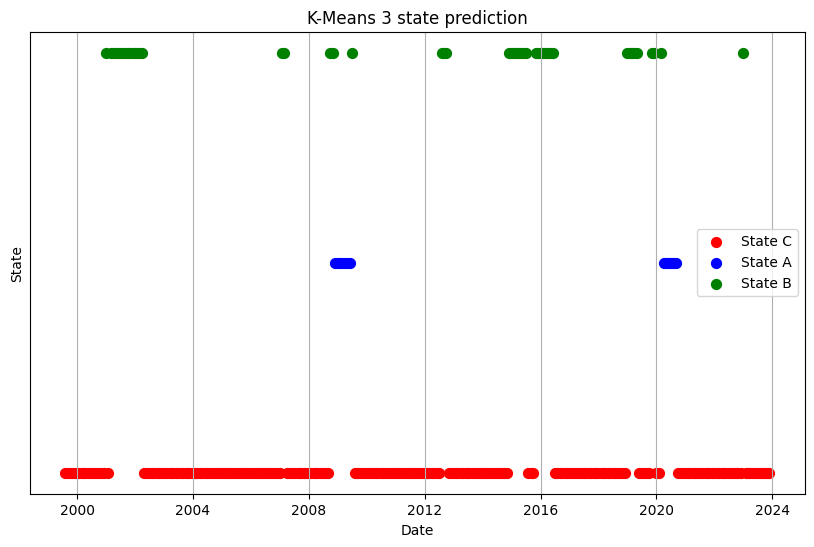

In [11]:
macro = pd.concat([nonfarm, initclaim, pce, indpro, ppi, cpi, oil, m2, house, neworders], axis=1, join='outer').ffill()['1998-11-30':]
macro = macro.reindex(pd.date_range(str(df_pct.index.min())[:10], str(df_pct.index.max())[:10])).ffill()
macro = macro.loc[df_pct.groupby(pd.Grouper(freq='1M')).tail(1).index].dropna() #sync dates with df with our series
macro = macro.pct_change().dropna()
macro = macro.rolling(6).apply(lambda x: geometric_mean_pctseries(x)).dropna() # smoothing series with a 3-months geometric mean

scaler = StandardScaler()
data_std = scaler.fit_transform(X = macro.values)

km_cluster=pd.DataFrame()
centroids = {}

for i in range(100):
    kmeans = KMeans(n_clusters=3, random_state=i, n_init="auto", max_iter=1000).fit(data_std)
    temp = pd.DataFrame(kmeans.labels_, index=macro.index, columns=[f'seed_{i}'])
    km_cluster = pd.concat([km_cluster, temp], axis=1)
    centroids[f'seed_{i}'] = kmeans.cluster_centers_

for i in km_cluster.columns:
    km_cluster[i].replace({km_cluster[i].value_counts().idxmax():'C'}, inplace=True)
    km_cluster[i].replace({km_cluster[i].value_counts().idxmin():'A'}, inplace=True)
    km_cluster[i].mask((km_cluster[i]!='A')&(km_cluster[i]!='C'), 'B', inplace=True)

km_cluster = km_cluster.mode(axis=1).rename({0:'km_state'}, axis=1)

plot_time_series(km_cluster['km_state'], title='K-Means 3 state prediction')

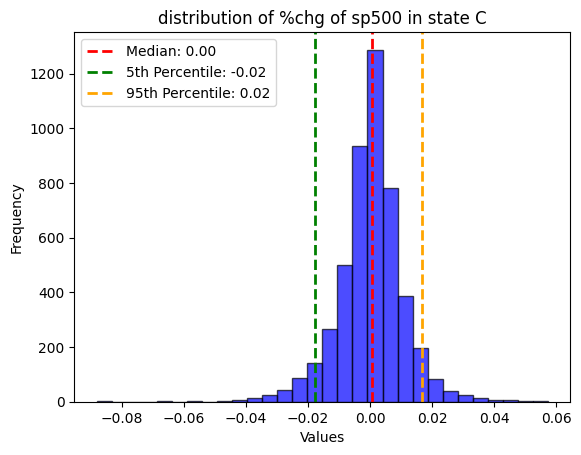

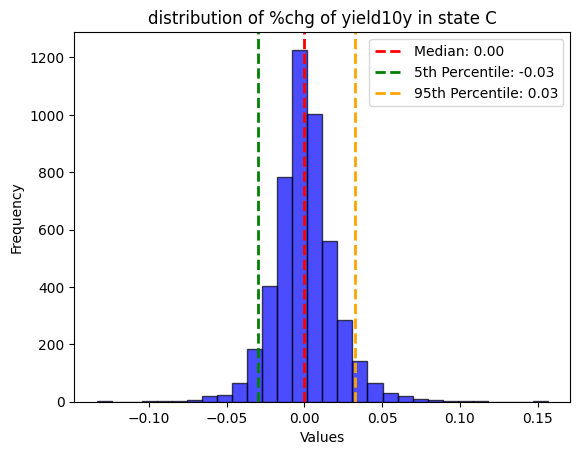

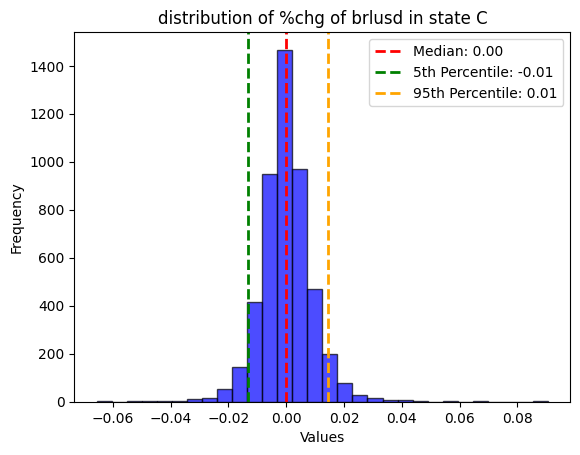

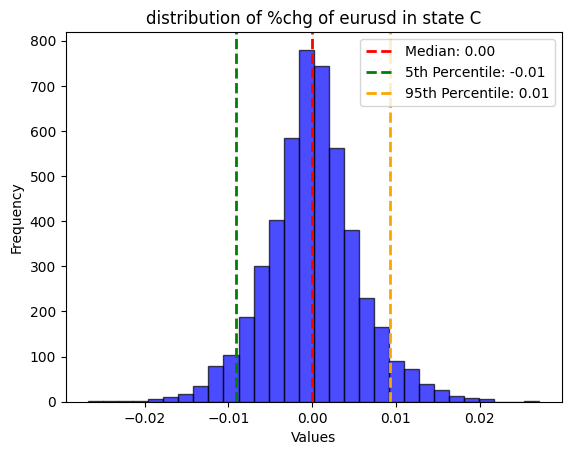

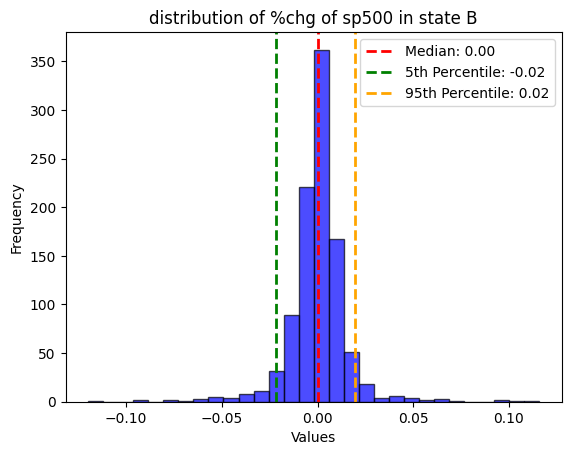

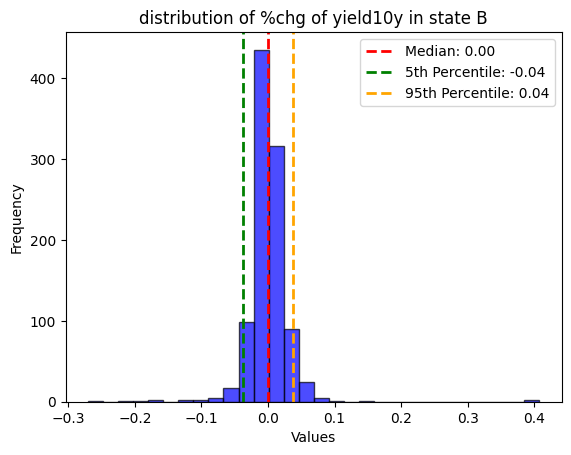

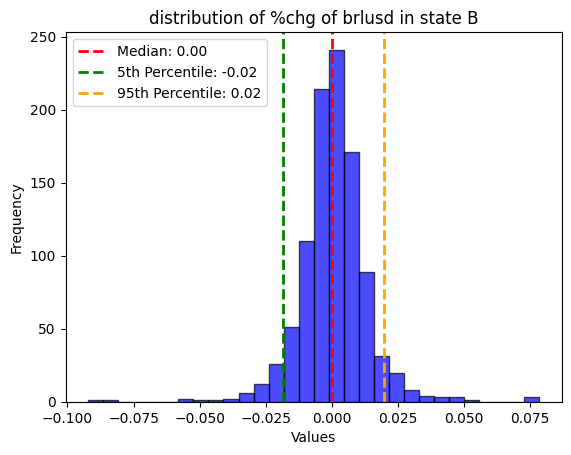

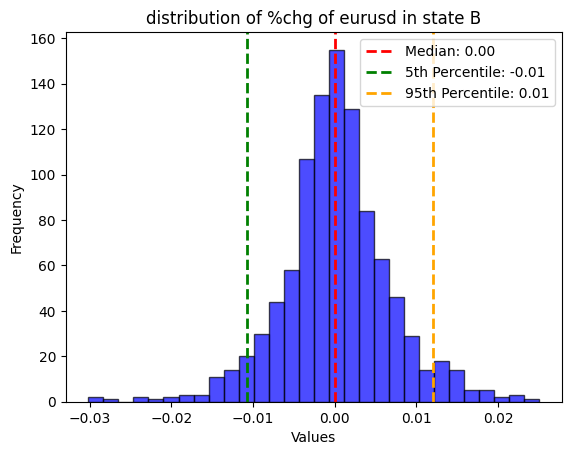

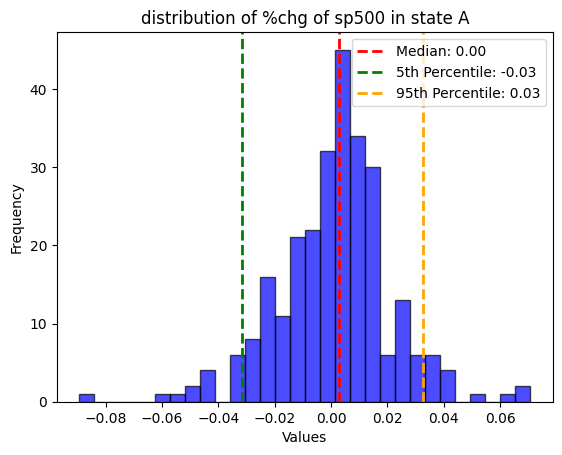

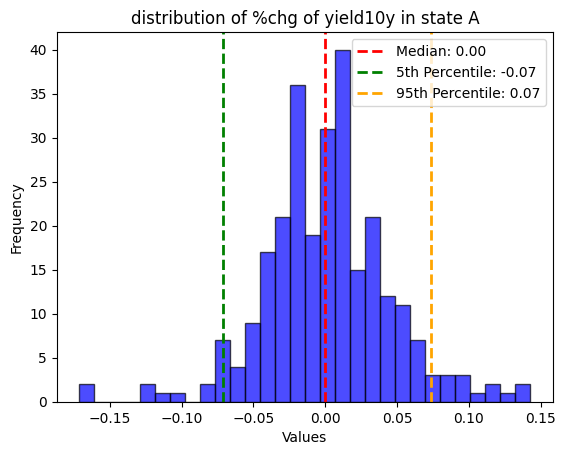

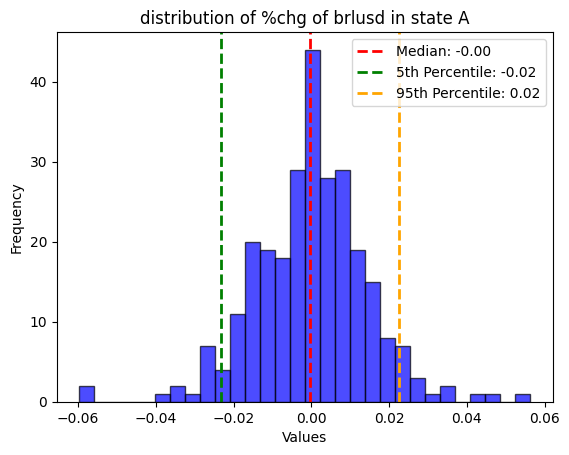

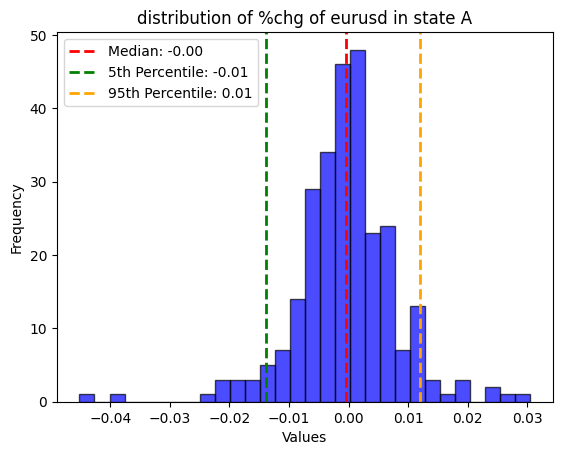

In [12]:
temp_km_rets = df_pct.join(km_cluster.reindex(pd.date_range(df_pct.index.min(), df_pct.index.max())).ffill()).dropna()

# plot histograms of %change in the 3 states derived from kmeans algo
for i in temp_km_rets['km_state'].unique():
    for j in df_pct.columns:
        plot_histogram_with_percentiles(temp_km_rets[temp_km_rets['km_state'] == i][j], title=f'distribution of %chg of {j} in state {i}')

In [13]:
# annualized volatilities in the 3 different states
temp_km_rets.groupby('km_state').std()*252**0.5

,sp500,yield10y,brlusd,eurusd
km_state,,,,
A,0.322735,0.711154,0.235046,0.136621
B,0.260295,0.525666,0.207321,0.105165
C,0.169500,0.314000,0.146330,0.087861


## Leading indicator property 

In [14]:
m_df = df.groupby(pd.Grouper(freq='1M')).tail(1)
m_df = m_df.pct_change().dropna()
feats = m_df.columns
targets = [i+'_tgt' for i in feats]

m_df = m_df.join(m_df.shift(-1), rsuffix='_tgt').dropna()



/var/folders/n4/_54fp6n536xgs8n2l5_p41vw0000gn/T/ipykernel_3771/939022252.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  m_df = m_df.pct_change().dropna()


/Users/v.b./Documents/VS_CODE/vscode_local/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/v.b./Documents/VS_CODE/vscode_local/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/v.b./Documents/VS_CODE/vscode_local/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/v.b./Documents/VS_CODE/vscode_local/venv/lib/python3.9/site-packages/sklearn/utils/validation.py

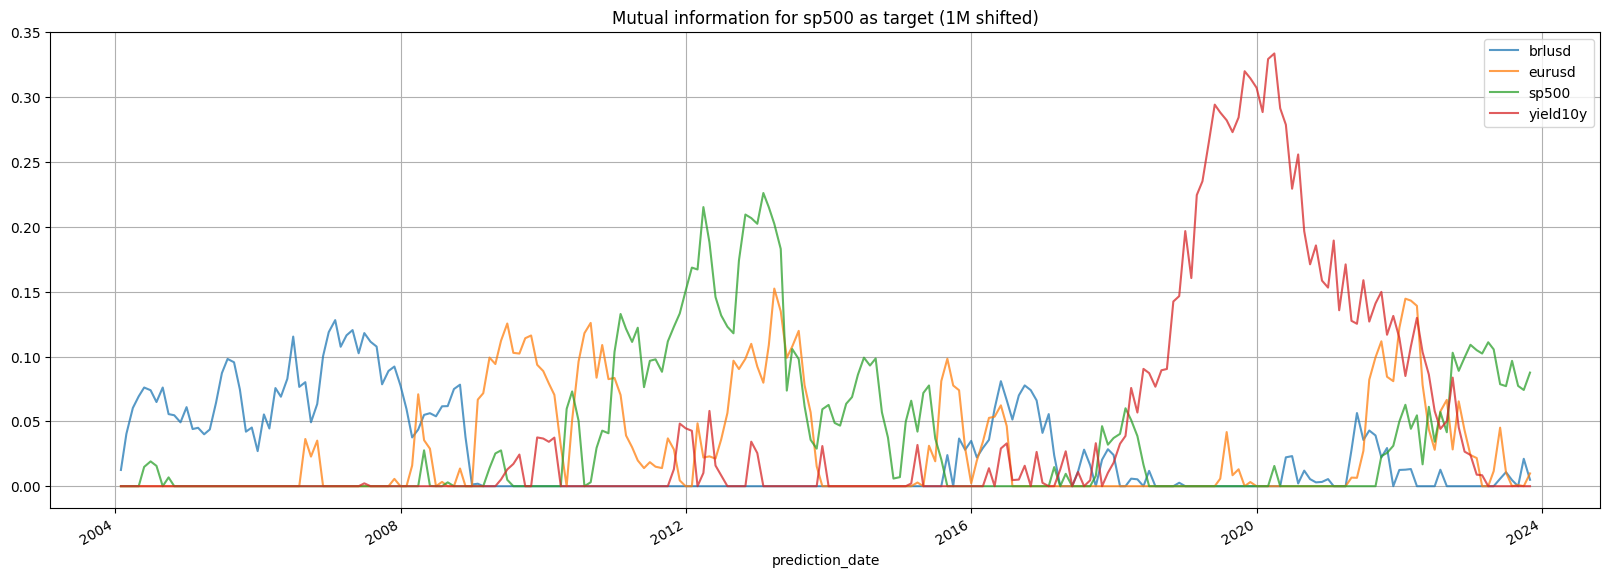

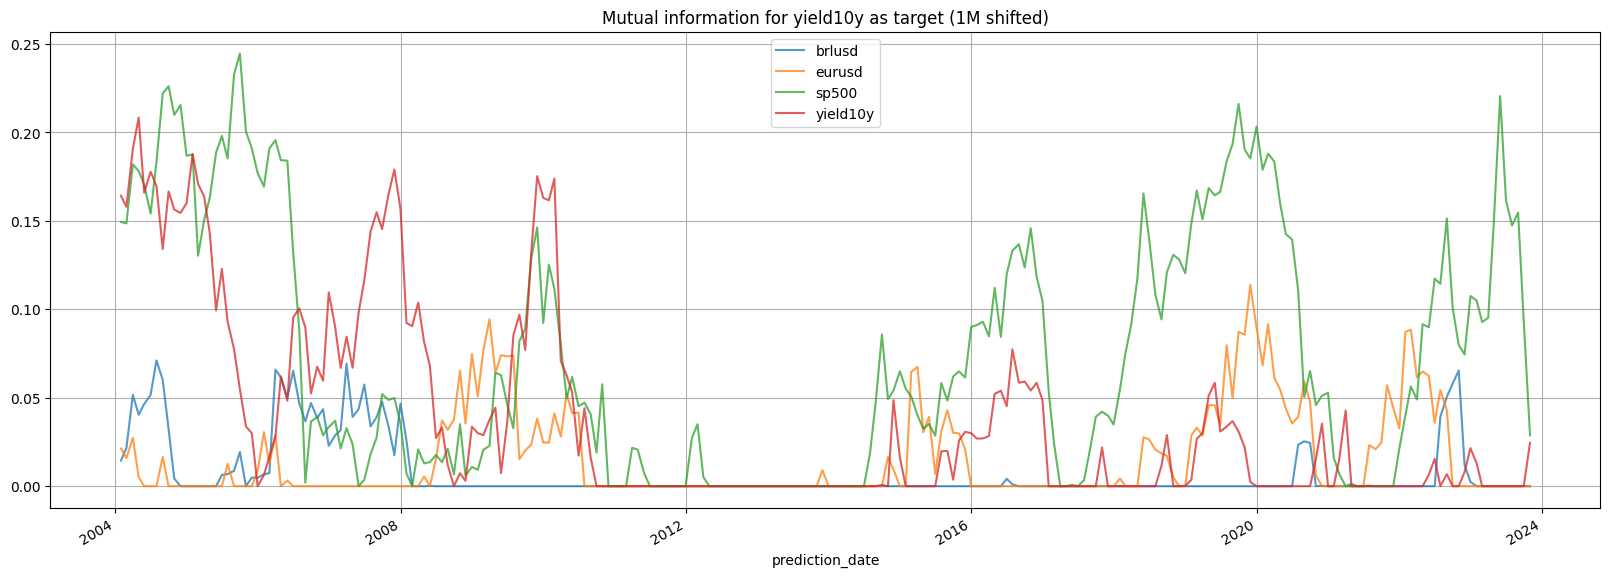

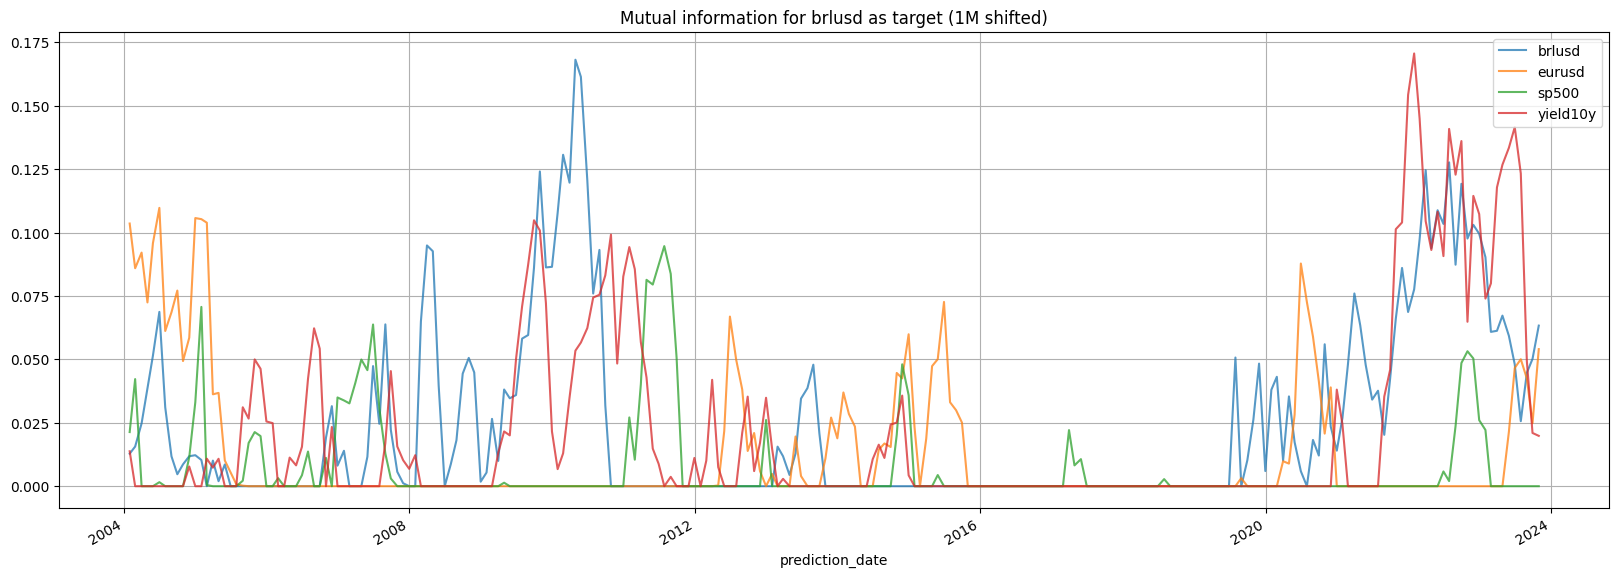

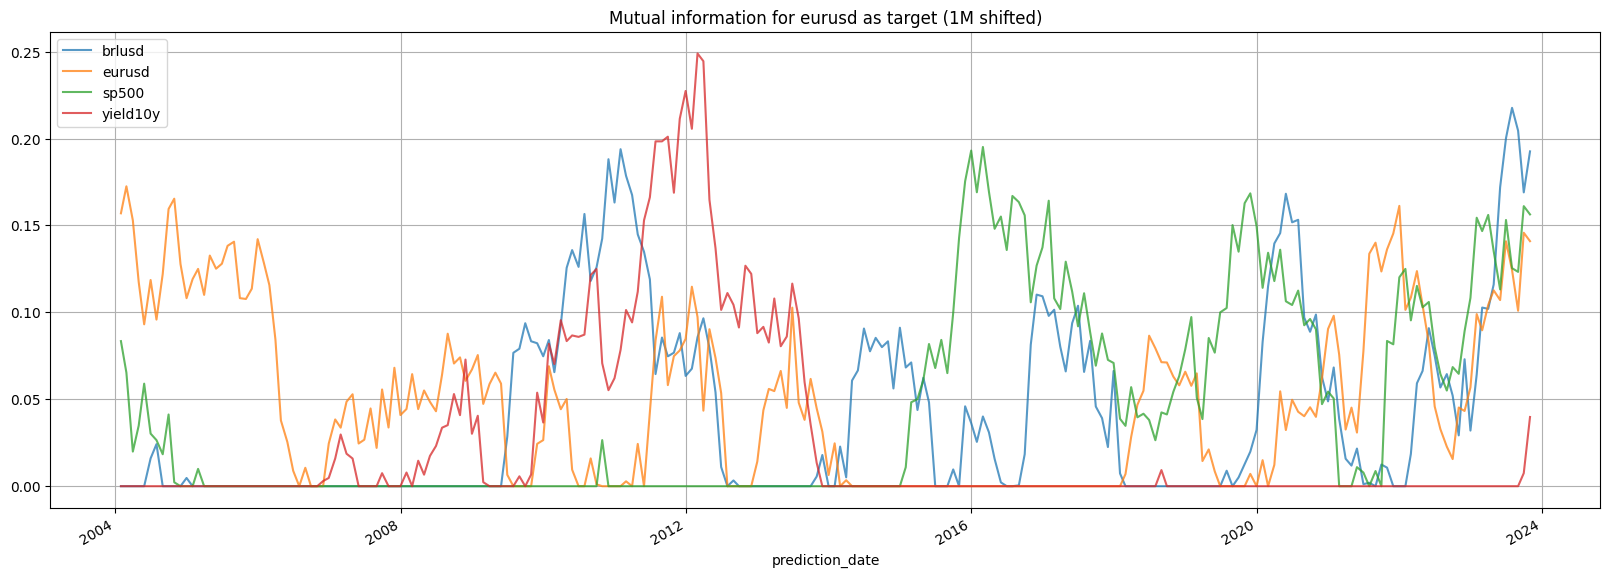

In [15]:
ROLL_WDW_MI = 12*5

mi = {}

for t in targets:
    for f in feats:
        for w in range(ROLL_WDW_MI, len(m_df)+1):
            temp = m_df.iloc[w-ROLL_WDW_MI:w].copy()
            mi[(t, f, temp.index.max())] = mutual_info_regression(temp[t].values.reshape(-1, 1), temp[f].values.reshape(-1, 1))


mi = pd.DataFrame(mi, index=['mutual_info']).T.reset_index().rename(
    {'level_0':'target', 'level_1':'feature', 'level_2':'prediction_date'}, axis=1).set_index('prediction_date')
        
for i in mi['target'].unique():
    mi[mi['target']==i].groupby(['feature'])['mutual_info'].plot(legend=True, alpha=0.75, figsize=(20,7), grid=True, title=f'Mutual information for {i[:-4]} as target (1M shifted)')
    plt.show()

